# Scope of Project


The goal is to predict whether a person has any of the three medical conditions or none of these along with its respective probability. Class 1 will be a person with prescence of any conditions and Class 0 will be person with no medical conditions. 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabpfn/tabpfn-0.1.9-py3-none-any.whl
/kaggle/input/tabpfn/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


# Import Libraries

In [3]:
# install Tabpfn 
!pip install tabpfn --no-index --find-links=file:///kaggle/input/tabpfn
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/tabpfn
Processing /kaggle/input/tabpfn/tabpfn-0.1.9-py3-none-any.whl


In [8]:
import random
import sklearn
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from matplotlib import style
from tqdm.notebook import tqdm
from collections import Counter
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tabpfn import TabPFNClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import log_loss, balanced_accuracy_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

plt.style.use('ggplot') 

#  suppress warning
warnings.filterwarnings('ignore')

# Import Data

#### **File Descriptions**

1. **train.csv** - The training set.
  - <u>Id</u> - Unique identifier for each observation.
  - <u>AB-GL</u> - Fifty-six anonymized health characteristics. *All are numeric except for EJ, which is categorical.*
  - Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.


2. **test.csv** - The test set. 
  - Goal is to predict the probability that a subject in this set belongs to each of the two classes.


3. **greeks.csv** - Supplemental metadata, only available for the training set.
  - <u>Alpha</u> - Identifies the type of age-related condition, if present.
  - <u>A</u> - No age-related condition. Corresponds to class 0.
  - <u>B, D, G</u> - The three age-related conditions. Correspond to class 1.
  - <u>Beta, Gamma, Delta</u> - Three experimental characteristics.
  - <u>Epsilon</u> - The date that the data was collected from subject. All of the data in the training set was collected before test set.


4. **sample_submission.csv** - Demonstration of correct submission format.

In [9]:
# for suppressing some sections when debugging
flag_debug = True
flag_EDA = True
flag_backElimination = True
flag_smote = True

# load data
greeks_ori = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
train_ori = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_ori = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

if False:
    n = 40
    greeks_ori = greeks_ori[:n]
    train_ori = train_ori[:n]
    test_ori = test_ori[:n]


# make a copy from original train data
greeks = greeks_ori.copy(deep = True)
train = train_ori.copy(deep = True)
test = test_ori.copy(deep = True)

# Helper Function

In [10]:
# function for getting some basic information about dataset
def data_info(dataset):
    print(f'Data has {dataset.shape[0]} rows and {dataset.shape[1]} columns \n')
    display(dataset.head())
    print('\n Info. of data: \n')
    print(dataset.info())
    print('------------------------------------------------------')
    
def balanced_log_loss(y_true, y_pred):
    if flag_debug:
        print('bll y_true: ', y_true)
        print('bll y_pred: ', y_pred)
    N_0 = np.sum(1 - y_true) # count number of class 0
    N_1 = np.sum(y_true) # count number of class 1

    w_0 = 1 / N_0
    w_1 = 1 / N_1

    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15) # probability of observation belongs to class1
    p_0 = 1 - p_1 # probability of observation belongs to class 0

    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = (w_0 * log_loss_0 + w_1 * log_loss_1) / 2

    return balanced_log_loss  

# function for model evaluation
def eval_metrics(model, y, y_pred, y_pred_proba):
    y_df_pred = pd.DataFrame(y_pred)
    sampleWeight = compute_sample_weight(class_weight = 'balanced', y = y)
    logloss = log_loss(y, y_pred_proba, eps = 1e-15, sample_weight = sampleWeight)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'Scoring Metrics for {model}')
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(f'\n Log loss: {logloss}\n')
    print('------------------------------------')
    clf_report = classification_report(y, y_pred)
    print('\n Classification report: \n', clf_report)
    print('------------------------------------')
    print('Balanced Accuracy Score: {:.2f}'.format(metrics.balanced_accuracy_score(y, y_df_pred)))
    print('Accuracy Score: {:.2f}'.format(metrics.accuracy_score(y, y_df_pred)))
    print('Precision Score: {:.2f}'.format(metrics.precision_score(y, y_df_pred)))
    print('Recall Score: {:.2f}'.format(metrics.recall_score(y, y_df_pred)))
    print('F1 Score: {:.2f}'.format(metrics.f1_score(y, y_df_pred)))
    print('ROC AUC Score: {:.2f}\n\n'.format(metrics.roc_auc_score(y, y_df_pred)))

# Exploratory Data Analysis (EDA)

In [6]:
# get some basic info. of file greeks
data_info(greeks)

Data has 617 rows and 6 columns 



Id Alpha Beta Gamma Delta    Epsilon
0  000ff2bfdfe9     B    C     G     D  3/19/2019
1  007255e47698     A    C     M     B    Unknown
2  013f2bd269f5     A    C     M     B    Unknown
3  043ac50845d5     A    C     M     B    Unknown
4  044fb8a146ec     D    B     F     B  3/25/2020


 Info. of data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       617 non-null    object
 1   Alpha    617 non-null    object
 2   Beta     617 non-null    object
 3   Gamma    617 non-null    object
 4   Delta    617 non-null    object
 5   Epsilon  617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB
None
------------------------------------------------------


In [7]:
# get some basic info. of training data
data_info(train)

Data has 617 rows and 58 columns 



Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.611063   2003.810319  22.136229  69.834944   
1  0.568932   9.292698   72.611063  27981.562750  29.135430  32.131996   
2  1.198821  37.077772   88.609437  13676.957810  28.022851  35.192676   
3  0.284466  18.529584   82.416803   2094.262452  39.948656  90.493248   
4  0.121914  16.408728  146.109943   8524.370502  45.381316  36.262628   

          GL  Class  
0   0.120343      1  
1  21.978000      0  
2   0.196941      0  
3   0.155829      0  
4   0.096614      1  

[5 rows x 58 columns]


 Info. of data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null

Data type of column **Id** and **EJ** are object instead of numerical, so label encoding may need to apply to column **EJ** for downstream consumption.

In [8]:
# get some info. of test data
data_info(test)

Data has 5 rows and 57 columns 



Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]


 Info. of data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      

As what are shown in training data set, data type of column **Id** and **EJ** are object instead numerical.

In [9]:
# get some info. of sample submission and its format
data_info(sample_submission)

Data has 5 rows and 3 columns 



Id  class_0  class_1
0  00eed32682bb      0.5      0.5
1  010ebe33f668      0.5      0.5
2  02fa521e1838      0.5      0.5
3  040e15f562a2      0.5      0.5
4  046e85c7cc7f      0.5      0.5


 Info. of data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       5 non-null      object 
 1   class_0  5 non-null      float64
 2   class_1  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 248.0+ bytes
None
------------------------------------------------------


Value counts of class 0 and class 1: 
0    509
1    108
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Occurrence')

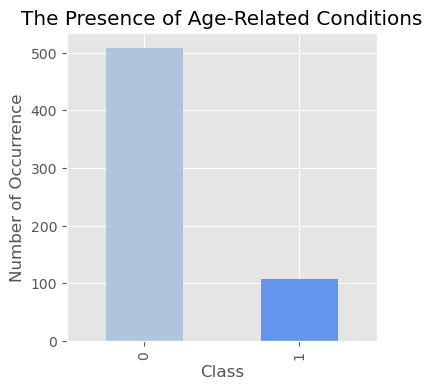

In [10]:
# find number of occurrences of Class 0 and Class 1
print('Value counts of class 0 and class 1: ', train['Class'].value_counts(), sep = '\n')

# plot bar chart for visualization
fig, ax = plt.subplots()
train['Class'].value_counts().plot(kind = 'bar', figsize = [4,4],
                                   color = ['lightsteelblue', 'cornflowerblue'],
                                   title = 'The Presence of Age-Related Conditions')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Occurrence')

Percentage of class 0 and class 1: 
0    82.495948
1    17.504052
Name: Class, dtype: float64


<Axes: ylabel='Class'>

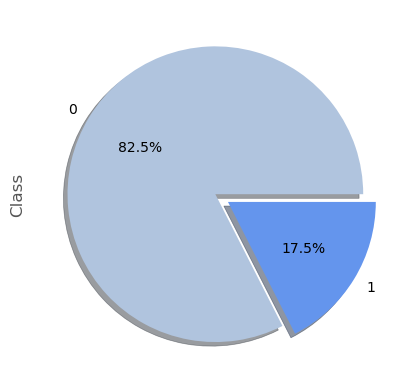

In [11]:
# calculate rate of occurrences of Class 0 and Class 1
print('Percentage of class 0 and class 1: ', train['Class'].value_counts(normalize = True)*100, sep = '\n')

# plot pie chart for visualization 
train['Class'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%',
                                   colors = ['lightsteelblue', 'cornflowerblue'],
                                   shadow = True,
                                   explode = ([0,0.1]))

From the rate shown above, Class 0 makes up 82.5% of the training dataset and Class 1 only makes up about 17.5%. Thus, the data is imbalanced and requires to be processed with oversampling or undersampling later before modelling.

* **Class 0** means a subject **has not** diagnosed with any of the age-related medical conditions. 
* **Class 1** means a subject **has** diagnosed with any of the three age-related medical conditions.

In [12]:
# check for duplication
print('Check for duplication: ',train.duplicated().all())

Check for duplication:  False


From the above result, there is no duplication in the training data.

In [13]:
# check for missing/null values in train file
print('Check for missing/null values in ' + '\033[1m' + 'train' + '\033[0m' + ' file: \n')
train.isnull().sum()

Check for missing/null values in train file: 



Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [14]:
# check for missing/null values in test file
print('Check for missing/null values in ' + '\033[1m' + 'test' + '\033[0m' + ' file: \n')
test.isnull().sum()

Check for missing/null values in test file: 



Id     0
AB     0
AF     0
AH     0
AM     0
AR     0
AX     0
AY     0
AZ     0
BC     0
BD     0
BN     0
BP     0
BQ     0
BR     0
BZ     0
CB     0
CC     0
CD     0
CF     0
CH     0
CL     0
CR     0
CS     0
CU     0
CW     0
DA     0
DE     0
DF     0
DH     0
DI     0
DL     0
DN     0
DU     0
DV     0
DY     0
EB     0
EE     0
EG     0
EH     0
EJ     0
EL     0
EP     0
EU     0
FC     0
FD     0
FE     0
FI     0
FL     0
FR     0
FS     0
GB     0
GE     0
GF     0
GH     0
GI     0
GL     0
dtype: int64

In [15]:
# check for missing/null values in greeks file
print('Check for missing/null values in ' + '\033[1m' + 'greeks' + '\033[0m' + ' file: \n')
greeks.isnull().sum()

Check for missing/null values in greeks file: 



Id         0
Alpha      0
Beta       0
Gamma      0
Delta      0
Epsilon    0
dtype: int64

From the results shown, there are some columns with missing/null values in train file. Thus, the missing values may need to be dealt with before modelling.

There is no missing/null values in both test and greeks file repectively.

In [16]:
# get some ideas about descriptive statistics
train.describe().T

count          mean           std          min          25%  \
AB     617.0      0.477149      0.468388     0.081187     0.252107   
AF     617.0   3502.013221   2300.322717   192.593280  2197.345480   
AH     617.0    118.624513    127.838950    85.200147    85.200147   
AM     617.0     38.968552     69.728226     3.177522    12.270314   
AR     617.0     10.128242     10.518877     8.138688     8.138688   
AX     617.0      5.545576      2.551696     0.699861     4.128294   
AY     617.0      0.060320      0.416817     0.025578     0.025578   
AZ     617.0     10.566447      4.350645     3.396778     8.129580   
BC     617.0      8.053012     65.166943     1.229900     1.229900   
BD     617.0   5350.388655   3021.326641  1693.624320  4155.702870   
BN     617.0     21.419492      3.478278     9.886800    19.420500   
BP     617.0    231.322223    183.992505    72.948951   156.847239   
BQ     557.0     98.328737     96.479371     1.331155    27.834425   
BR     617.0   1218.133238   7575.293707    51.216883   424.990642   
BZ     617.0    550.632525   2076.371275   257.432377   257.432377   
CB     615.0     77.104151    159.049302    12.499760    23.317567   
CC     614.0      0.688801      0.263994     0.176874     0.563688   
CD     617.0     90.251735     51.585130    23.387600    64.724192   
CF     617.0     11.241064     13.571133     0.510888     5.066306   
CH     617.0      0.030615      0.014808     0.003184     0.023482   
CL     617.0      1.403761      1.922210     1.050225     1.050225   
CR     617.0      0.742262      0.281195     0.069225     0.589575   
CS     617.0     36.917590     17.266347    13.784111    29.782467   
CU     617.0      1.383792      0.538717     0.137925     1.070298   
CW     617.0     27.165653     14.645993     7.030640     7.030640   
DA     617.0     51.128326     21.210888     6.906400    37.942520   
DE     617.0    401.901299    317.745623    35.998895   188.815690   
DF     617.0      0.633884      1.912384     0.238680     0.238680   
DH     617.0      0.367002      0.112989     0.040995     0.295164   
DI     617.0    146.972099     86.084419    60.232470   102.703553   
DL     617.0     94.795377     28.243187    10.345600    78.232240   
DN     617.0     26.370568      8.038825     6.339496    20.888264   
DU     616.0      1.802900      9.034721     0.005518     0.005518   
DV     617.0      1.924830      1.484555     1.743070     1.743070   
DY     617.0     26.388989     18.116679     0.804068    14.715792   
EB     617.0      9.072700      6.200281     4.926396     5.965392   
EE     617.0      3.064778      2.058344     0.286201     1.648679   
EG     617.0   1731.248215   1790.227476   185.594100  1111.160625   
EH     617.0      0.305107      1.847499     0.003042     0.003042   
EL     557.0     69.582596     38.555707     5.394675    30.927468   
EP     617.0    105.060712     68.445620    78.526968    78.526968   
EU     617.0     69.117005    390.187057     3.828384     4.324656   
FC     616.0     71.341526    165.551545     7.534128    25.815384   
FD     617.0      6.930086     64.754262     0.296850     0.296850   
FE     617.0  10306.810737  11331.294051  1563.136688  5164.666260   
FI     617.0     10.111079      2.934025     3.583450     8.523098   
FL     616.0      5.433199     11.496257     0.173229     0.173229   
FR     617.0      3.533905     50.181948     0.497060     0.497060   
FS     615.0      0.421501      1.305365     0.067730     0.067730   
GB     617.0     20.724856      9.991907     4.102182    14.036718   
GE     617.0    131.714987    144.181524    72.611063    72.611063   
GF     617.0  14679.595398  19352.959387    13.038894  2798.992584   
GH     617.0     31.489716      9.864239     9.432735    25.034888   
GI     617.0     50.584437     36.266251     0.897628    23.011684   
GL     616.0      8.530961     10.327010     0.001129     0.124392   
Class  617.0      0.175041      0.380310     0.000000     0.000000   

               5

The means of the characteristics presented range widely from the descriptive statistics, so these characteristics may need to be standardized before modelling.

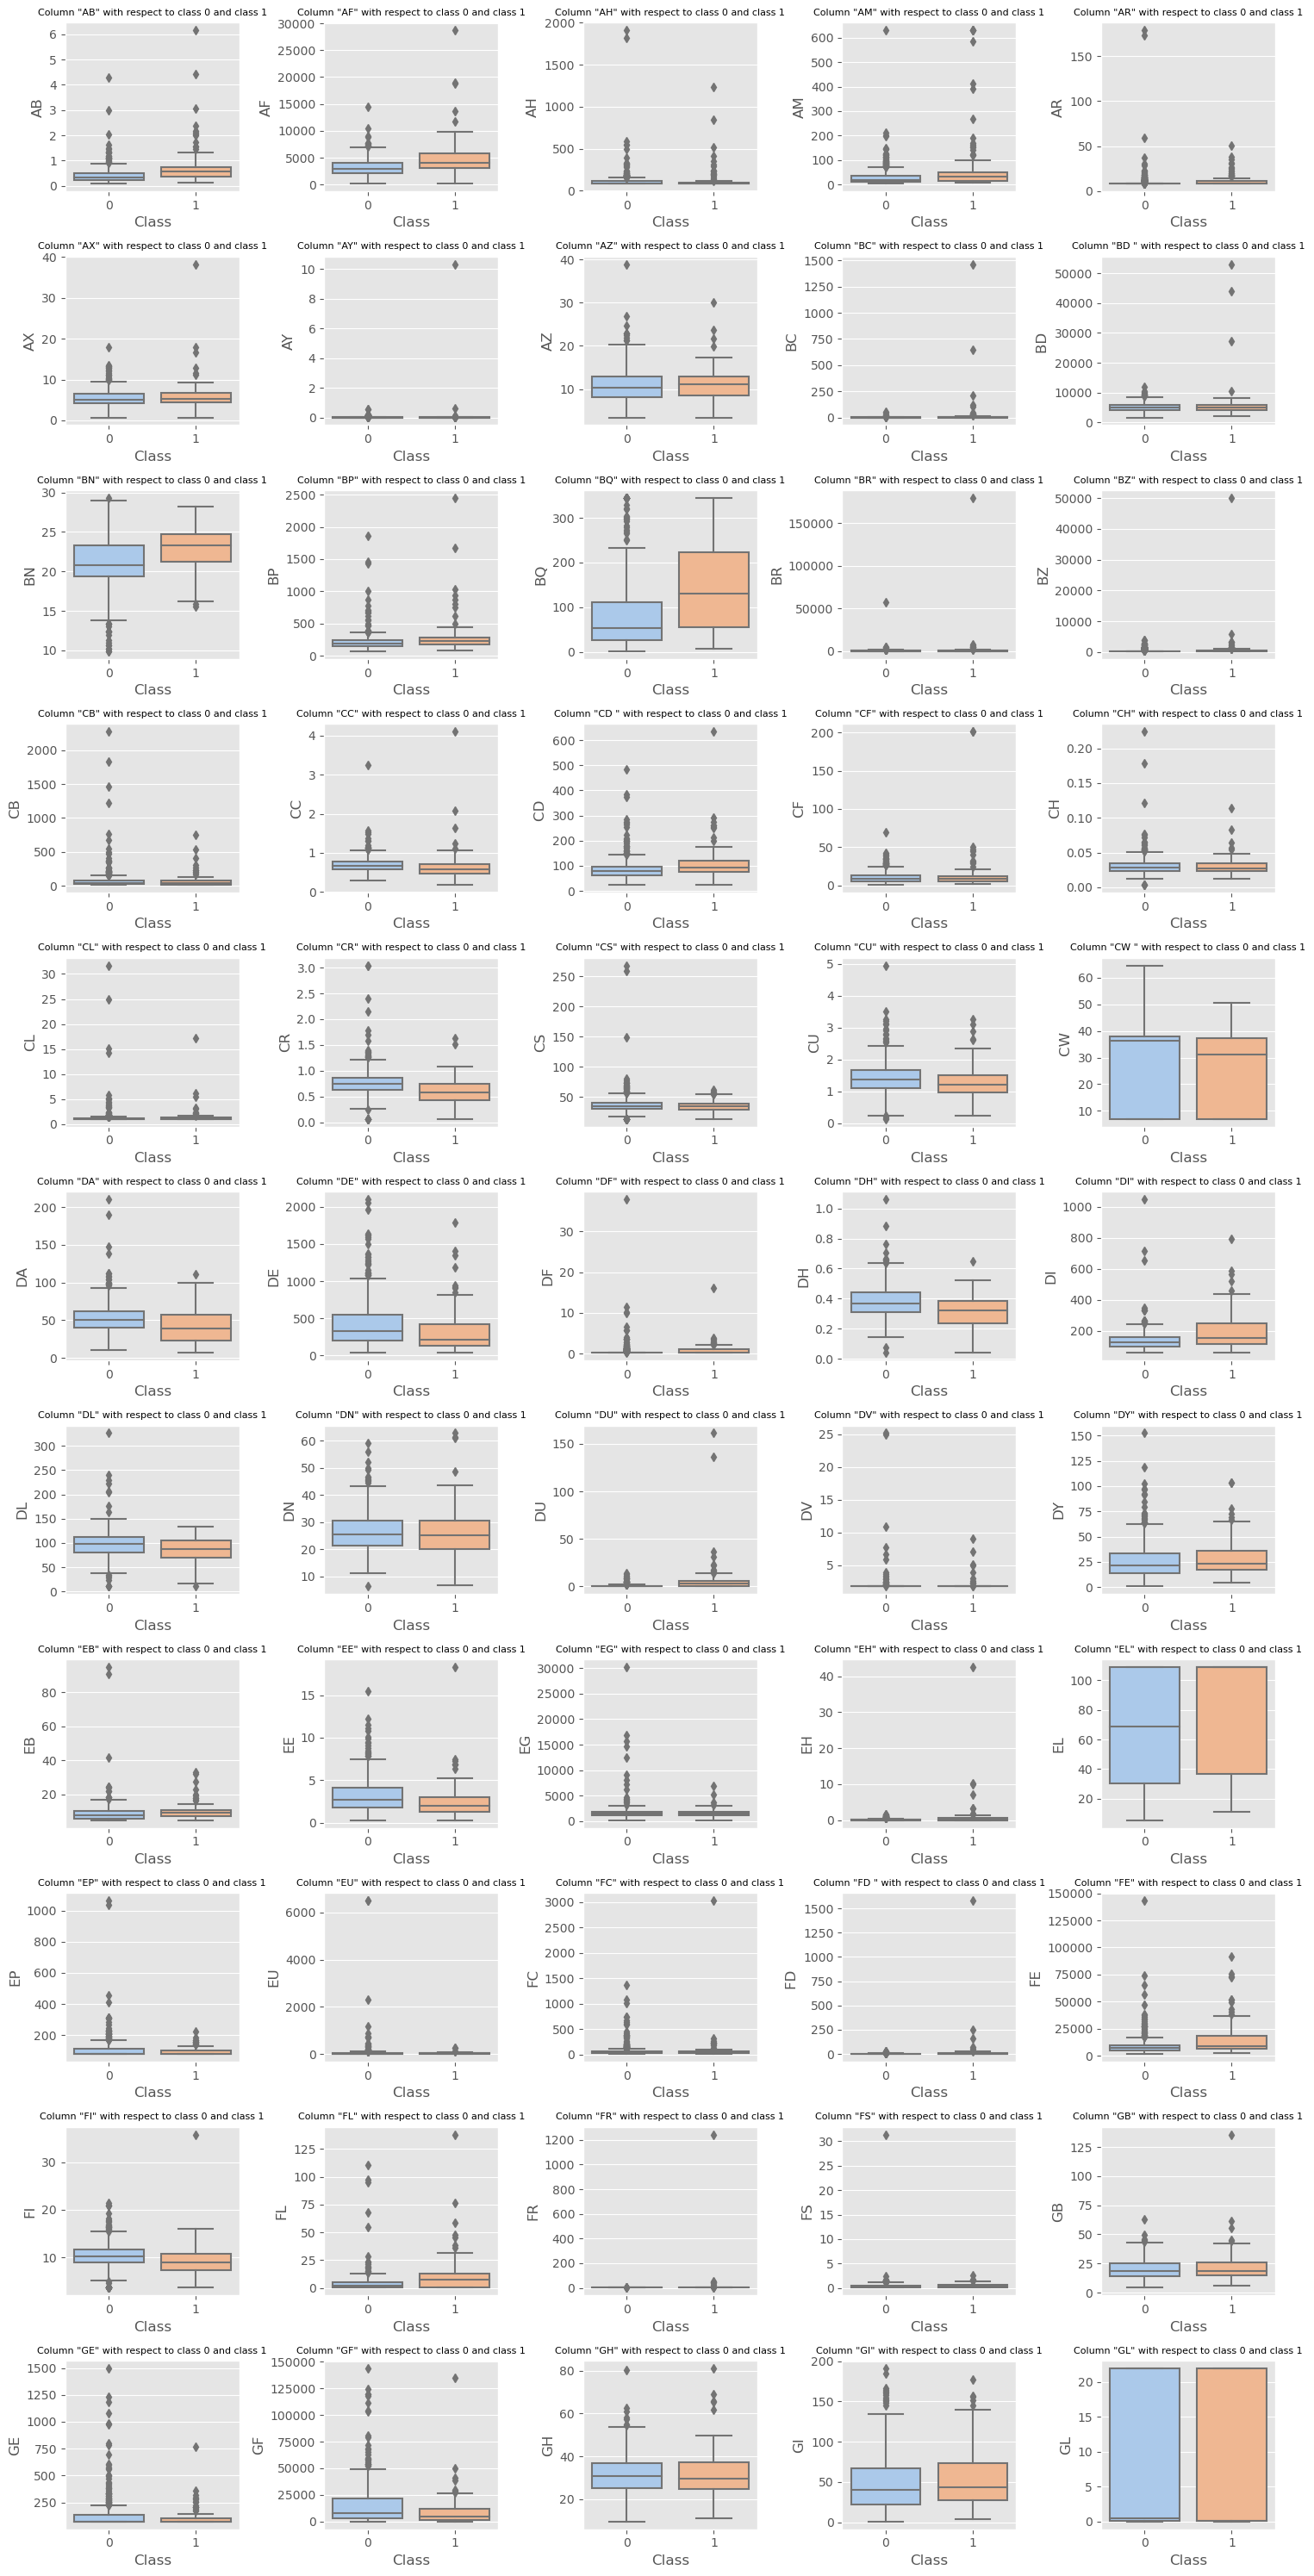

In [17]:
if flag_EDA:
    # boxplot for visually looking at descriptive statistics
    count = 1
    fig = plt.figure(figsize = (15,30))

    for col in train.loc[:, ~train.columns.isin(['Id', 'EJ', 'Class'])]:
        plt.subplot(11,5, count)
        plt.title(f'Column "{col}" with respect to class 0 and class 1', fontsize = 8)
        sns.boxplot(x = train['Class'], y = train[col], palette = 'pastel')
        count = count + 1

    plt.tight_layout()
    plt.show()

**Alpha**

Number of occurrence: 

A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64


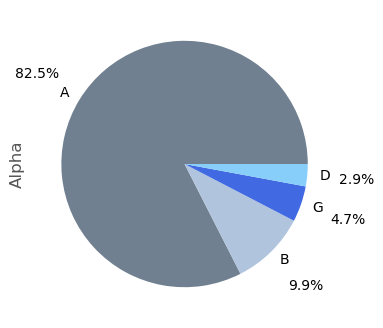

------------------------------------------------------------------
------------------------------------------------------------------
**Beta**

Number of occurrence: 

C    407
B    202
A      8
Name: Beta, dtype: int64


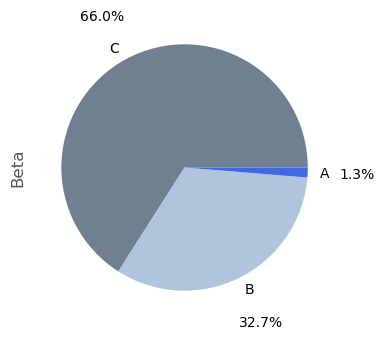

------------------------------------------------------------------
------------------------------------------------------------------
**Gamma**

Number of occurrence: 

M    445
N     64
H     53
B     18
A     11
F     10
G      8
E      8
Name: Gamma, dtype: int64


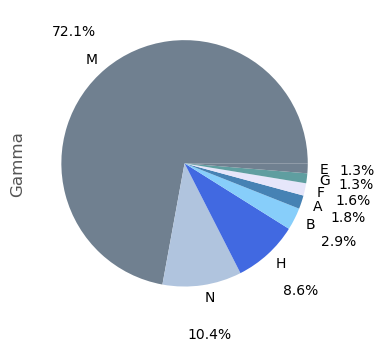

------------------------------------------------------------------
------------------------------------------------------------------
**Delta**

Number of occurrence: 

B    456
A     75
C     64
D     22
Name: Delta, dtype: int64


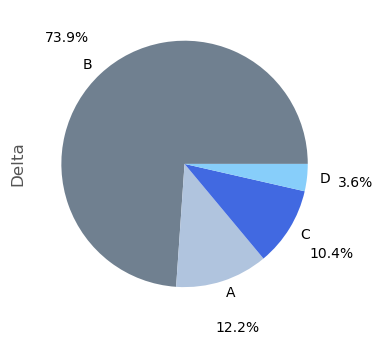

------------------------------------------------------------------
------------------------------------------------------------------


In [18]:
if flag_EDA:
    # check the percentage of presence of age-related conditions and the 3 experimental characteristics
    colors = ['slategrey', 'lightsteelblue', 'royalblue', 'lightskyblue', 'steelblue', 'lavender', 'cadetblue']

    # loop via greeks columns to get number of occurrence of each category and create pie plot
    for i in greeks.columns[1:-1]:
        print('\033[1m' + '**' + i + '**' + '\033[0m')
        value_count = greeks[i].value_counts()
        print('\nNumber of occurrence: \n', value_count, sep = '\n')

        # plot pie chart
        value_count.plot(kind = 'pie', figsize = (4,4), autopct = '%1.1f%%', pctdistance = 1.4, colors = colors)
        plt.show()
        print('------------------------------------------------------------------')
        print('------------------------------------------------------------------')


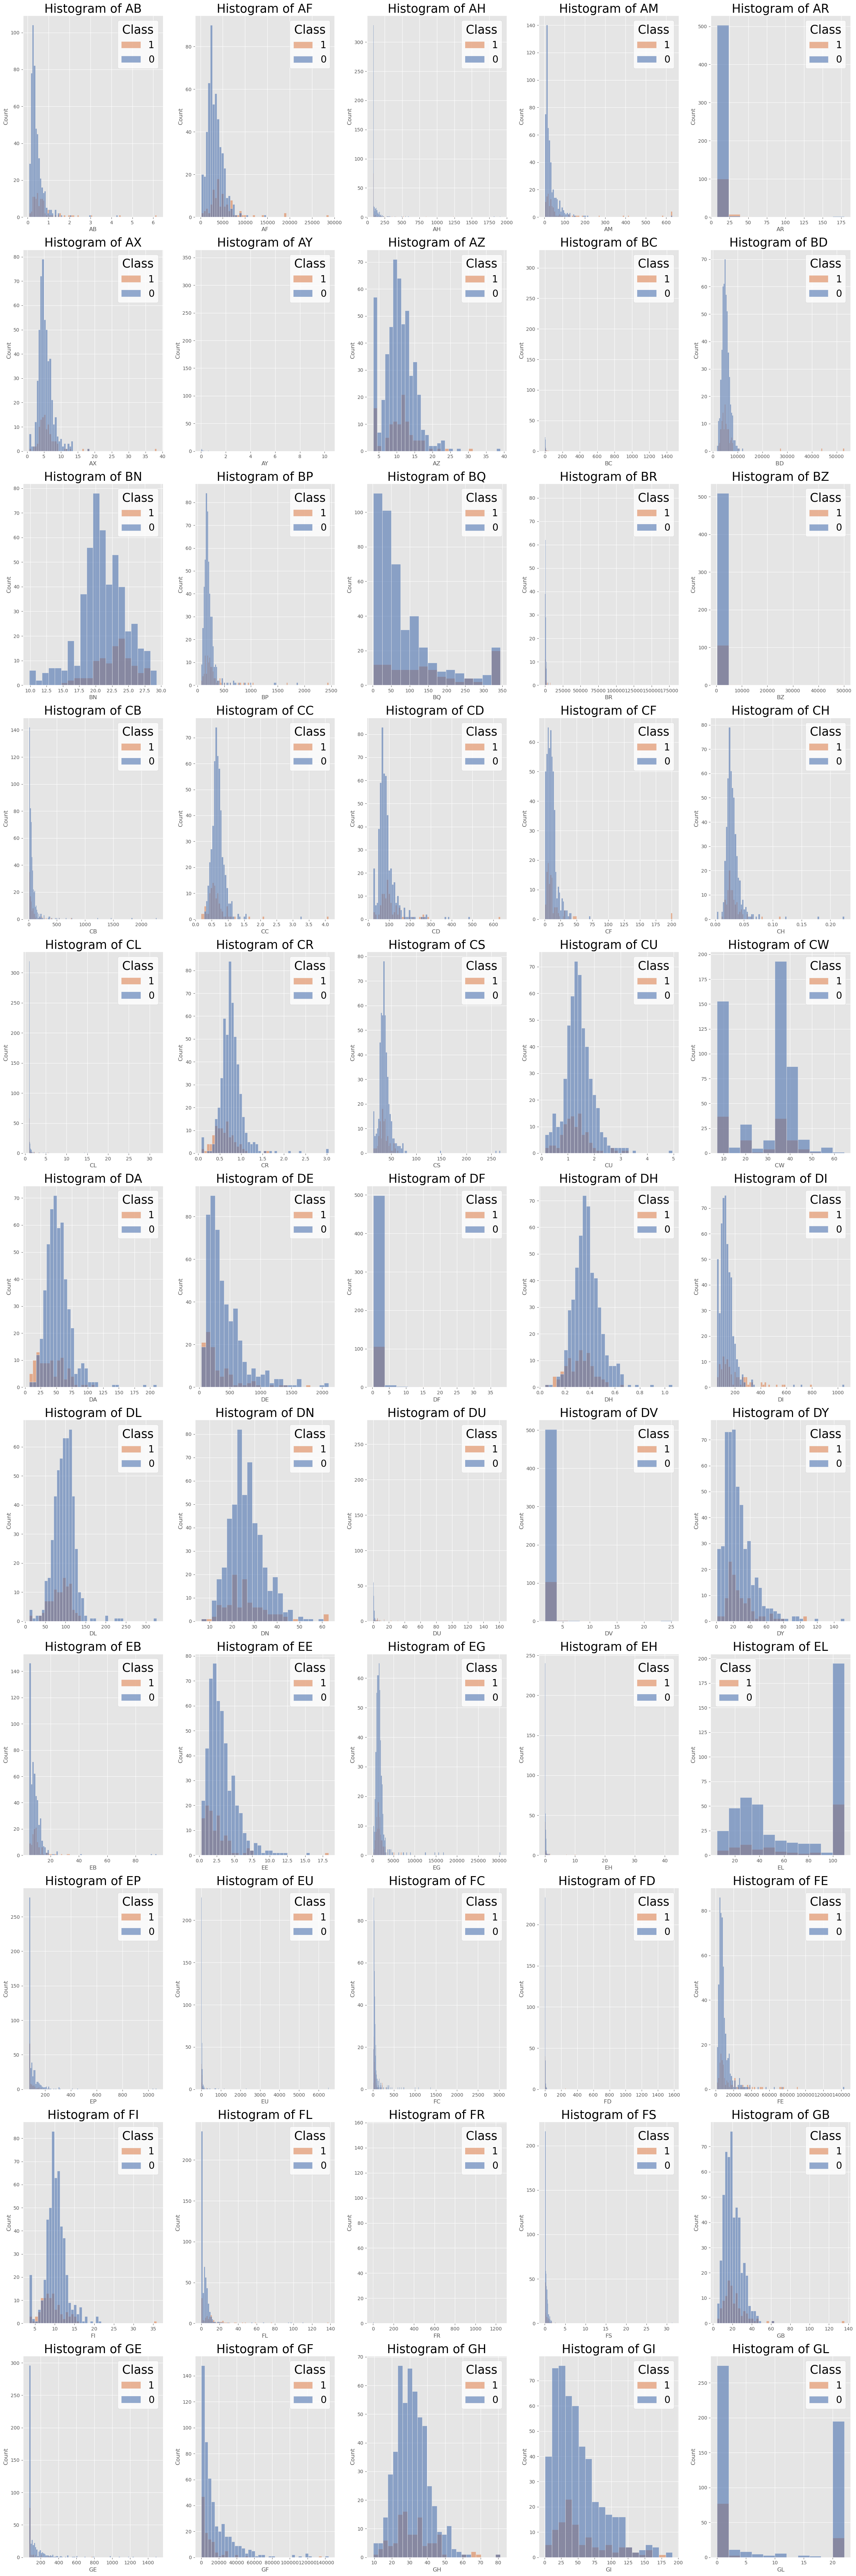

In [19]:
if flag_EDA:
    # plot histogram to check out the distribution of each numerical column from training data
    fig = plt.figure(figsize = (25,75))
    count = 1

    for col in train.loc[:,~train.columns.isin(['Id', 'EJ', 'Class'])]:
        plt.subplot(11, 5, count)
        plt.title(f'Histogram of {col}', fontsize = 25)
        sns.histplot(x = train[col], hue = train['Class'], palette = 'deep', alpha = 0.6)
        plt.legend(train['Class'], title = 'Class', title_fontsize = 25, fontsize = 20, facecolor = 'white')
        count = count + 1

    plt.tight_layout()
    plt.show()

The distribution from the resulting histogram for some columns are unclear due to the bins and outliers. However, some plots already clearly show the sign of long tails. To have a better look at the distribution, kernel density plot of each column may help further.

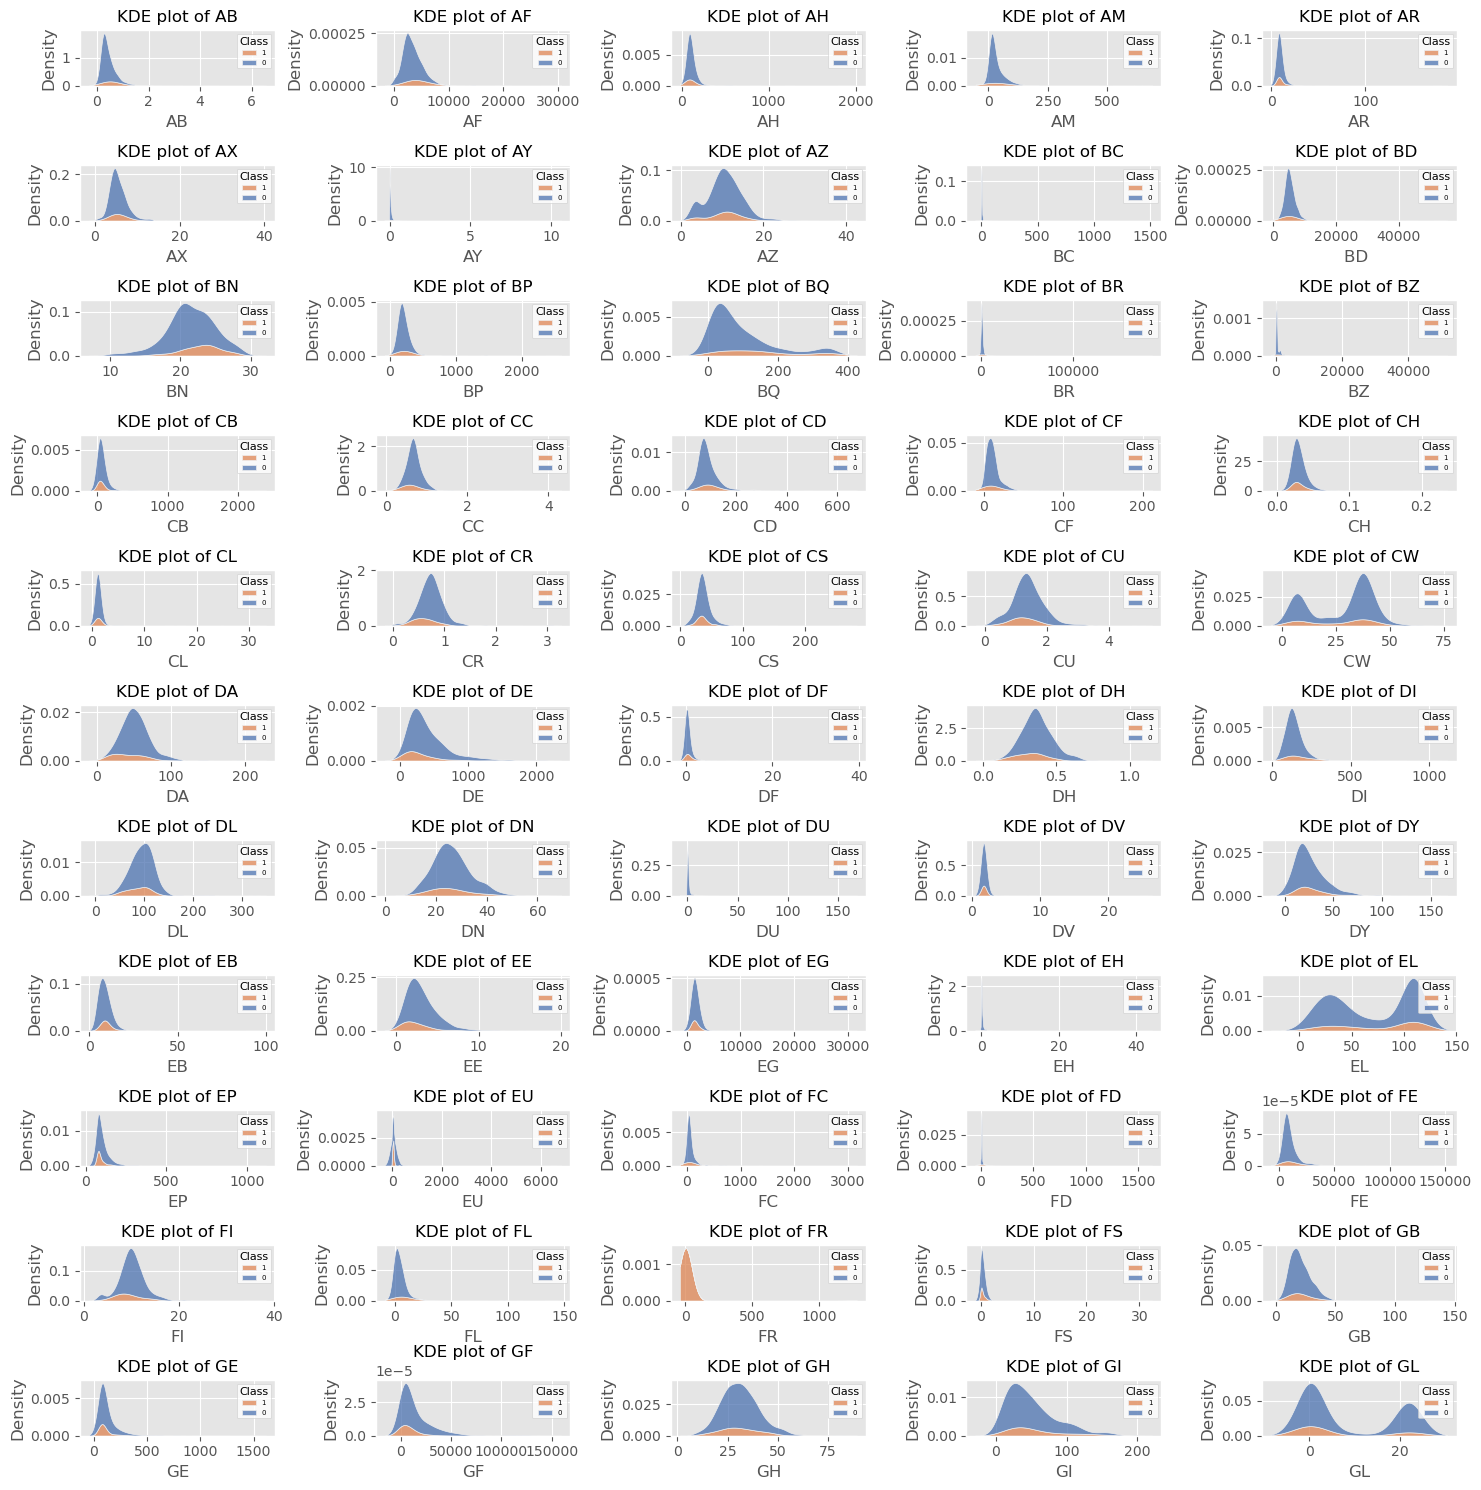

In [20]:
if flag_EDA:
    # plot kernel density plot(KDE) to examine tthe distribution of each numerical column from training data
    fig = plt.figure(figsize = (15,15))
    count = 1

    for col in train.loc[:, ~train.columns.isin(['Id','EJ','Class'])]:
        plt.subplot(11, 5, count)
        plt.title(f'KDE plot of {col}', fontsize = 12)
        sns.kdeplot(data = train, x = train[col], hue = train['Class'], multiple = 'stack', palette = 'deep')
        plt.legend(train['Class'], title = 'Class', title_fontsize = 8, fontsize = 5, facecolor = 'white')
        count = count + 1

    plt.tight_layout()
    plt.show()

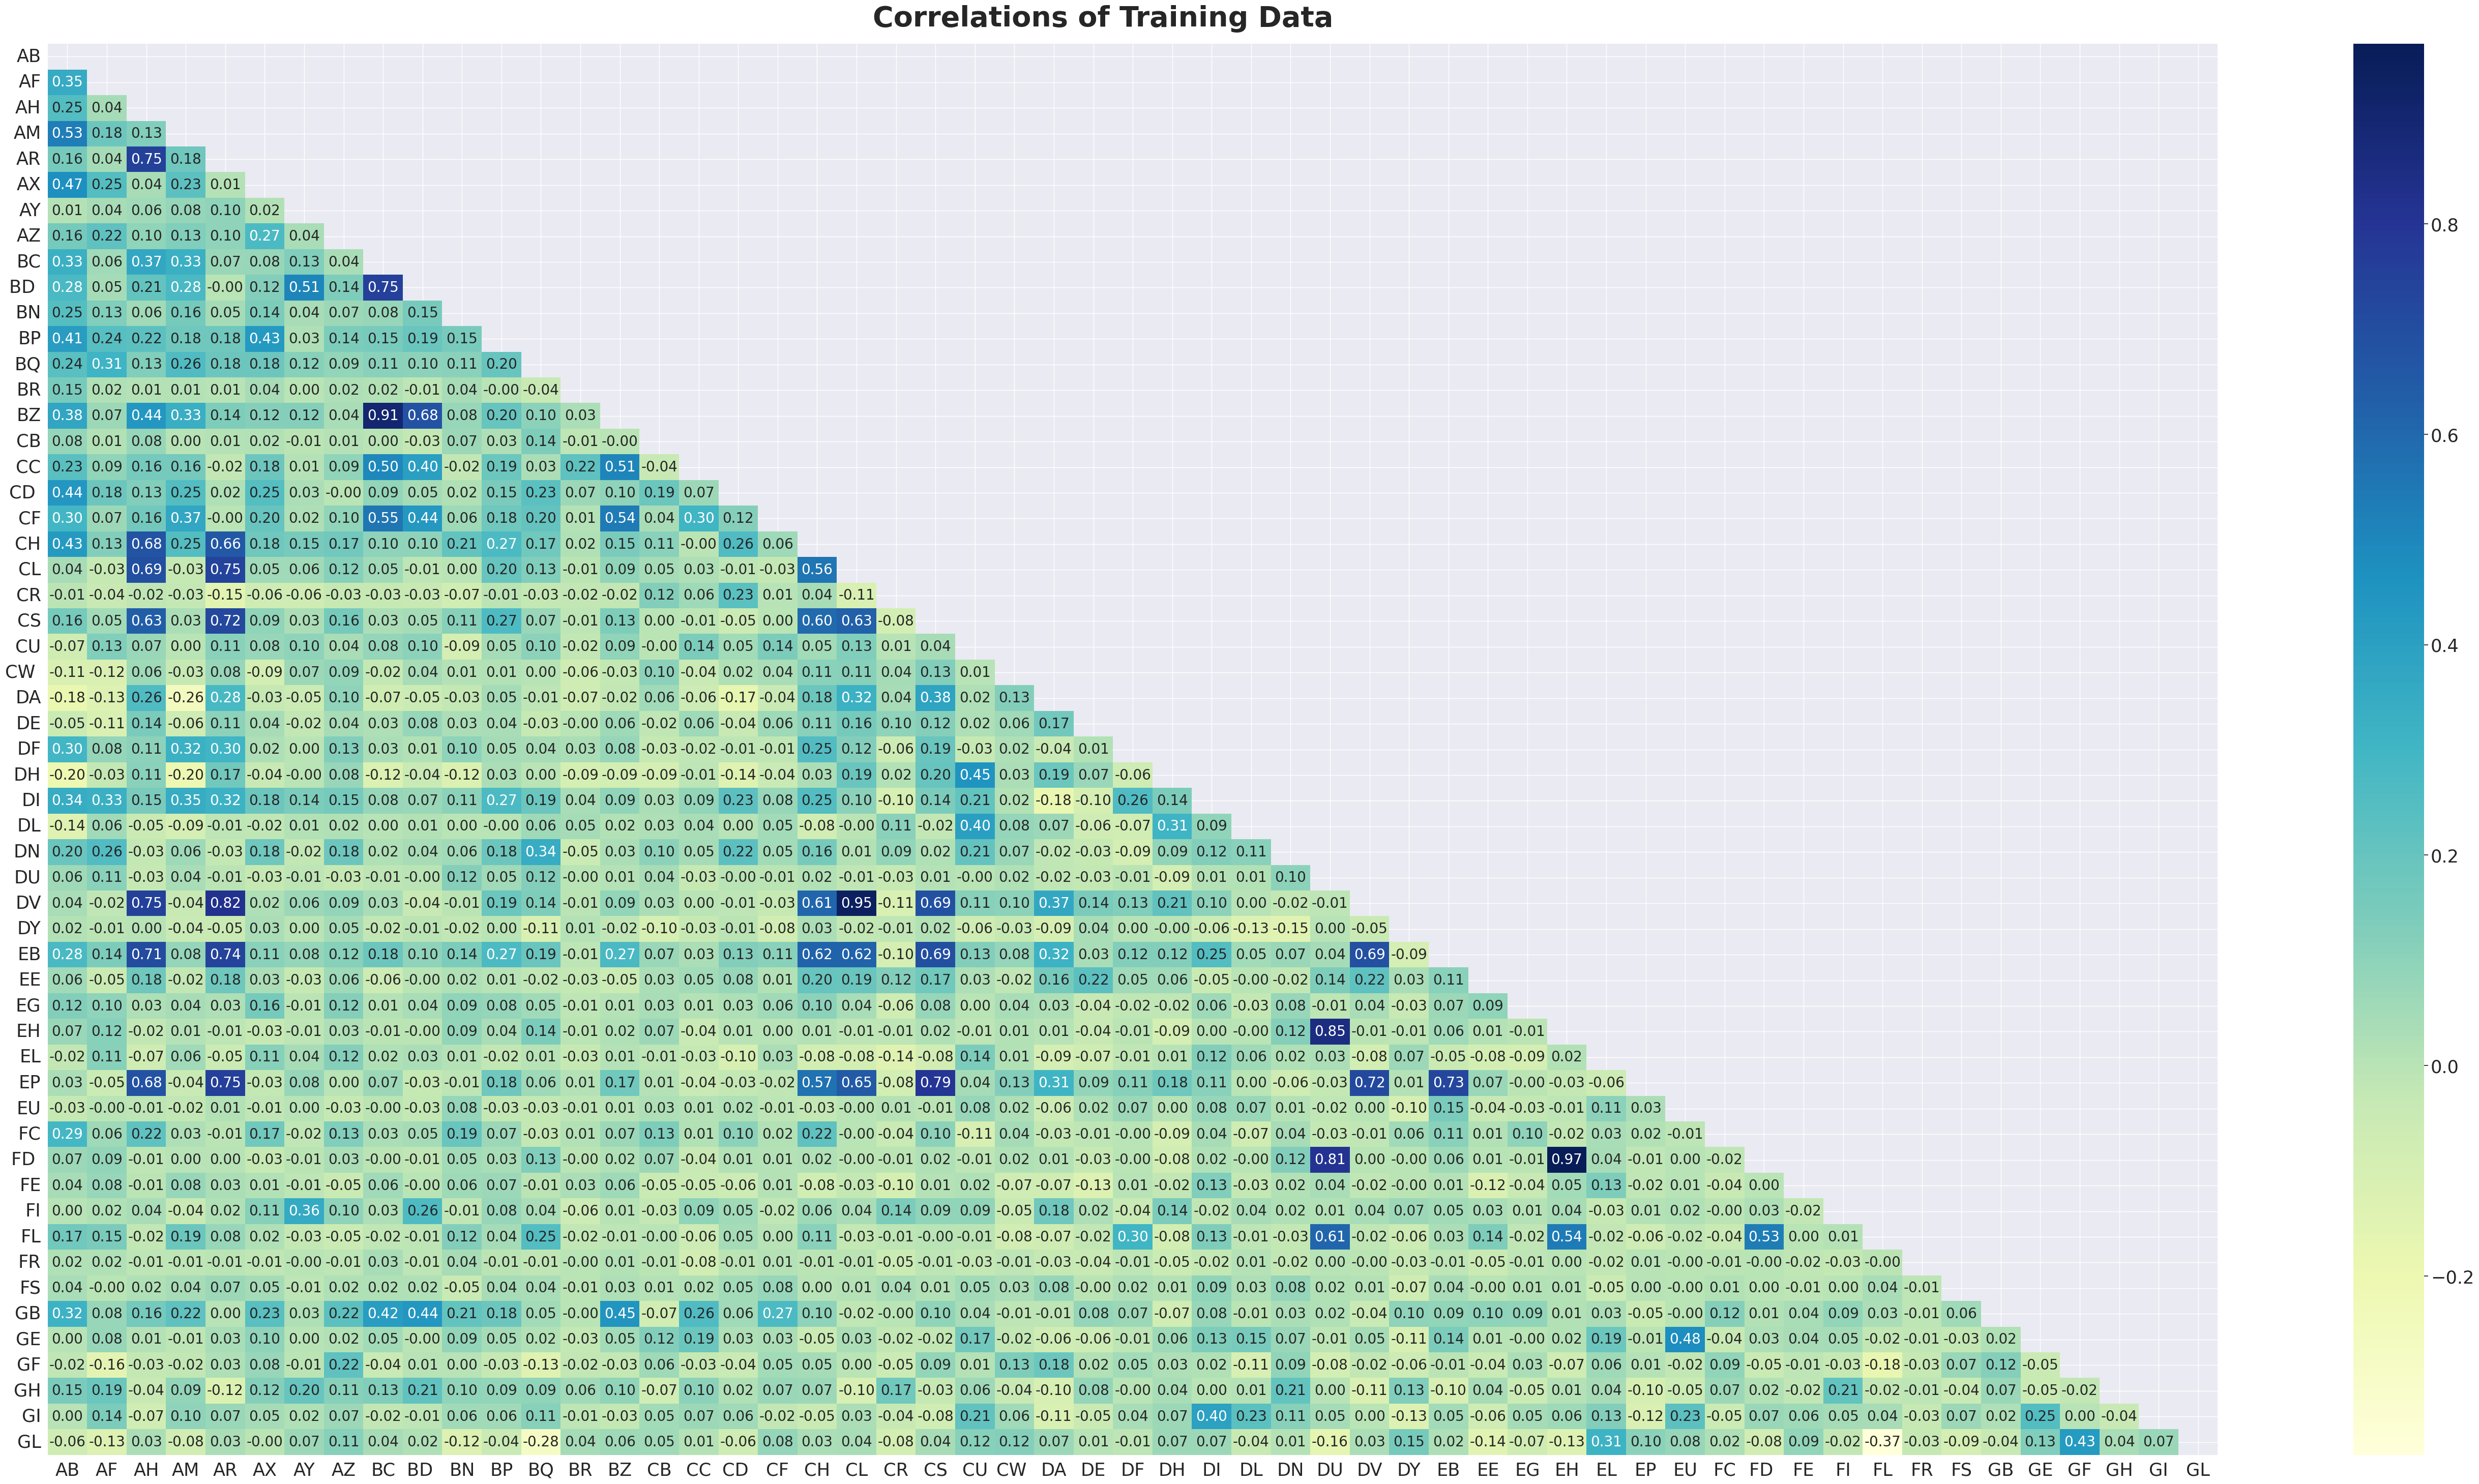

In [21]:
if flag_EDA:
    # create a triangle correlation heatmap (remove the repeated columns and rows)
    fig = plt.figure(figsize = (55,30))
    sns.set(font_scale = 2.3)

    # create a mask
    mask_train = np.triu(np.ones_like(train.loc[:, ~train.columns.isin(['Id', 'EJ', 'Class'])].corr()))

    # plot correlation heatmap
    train_corr_heatmap = sns.heatmap(train.loc[:, ~train.columns.isin(['Id', 'EJ', 'Class'])].corr(),
                                     cmap = 'YlGnBu',
                                     annot = True,
                                     fmt = '.2f',
                                     linewidth = 0,
                                     mask = mask_train,
                                     annot_kws = {'size':20})

    plt.suptitle('Correlations of Training Data', x = 0.4, fontsize = 40, fontweight = 'bold')
    plt.tight_layout()
    plt.show()

From the heatmap, it shows some features are highly correlated. Thus, some models required these highly correlated features to be removed first before training for better prediction results.

# Imputation of Missing Values and Standardization

In [12]:
# extract column names from train/test data set
train_col_name = train.columns.drop(['Id', 'EJ', 'Class'])
test_col_name = test.columns.drop(['Id', 'EJ'])

# instantiate KNN imputer for fill out missing values
imputer = KNNImputer(n_neighbors = 10)

# instantiate scaler to scale features
scaler = RobustScaler()

train_fillna = imputer.fit_transform(train.iloc[:, ~train.columns.isin(['Id', 'EJ', 'Class'])])
train_scaled = pd.DataFrame(scaler.fit_transform(train_fillna))

# no missing/null value in test set, so test set only needs to be scaled
test_scaled = pd.DataFrame(scaler.fit_transform(test.iloc[:, ~test.columns.isin(['Id', 'EJ'])]))

# add column names back to processed train data/test data
train_scaled.columns = train_col_name
test_scaled.columns = test_col_name

# drop all columns that is in train_scaled/test_scaled from train/test
train = train.drop(train_scaled, axis = 1)
test = test.drop(test_scaled, axis = 1)

# concatenate train/test and train_scaled/test_scaled together to make train/test set complete
train = pd.concat([train, train_scaled], axis = 1)
test = pd.concat([test, test_scaled], axis = 1)

print('Check whether missing values are filled in' + '\033[1m' + ' train ' + '\033[0m' + 'data: \n', train.isnull().sum(), sep = '\n')
print('\n Check the shape of' + '\033[1m' + ' train ' + '\033[0m' + 'data: ', train.shape, sep = '\n')
display(train.head())
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')
print('\n Check the shape of' + '\033[1m' + ' test ' + '\033[0m' + 'data: ', test.shape, sep = '\n')
display(test.head())

Check whether missing values are filled in train data: 

Id       0
EJ       0
Class    0
AB       0
AF       0
AH       0
AM       0
AR       0
AX       0
AY       0
AZ       0
BC       0
BD       0
BN       0
BP       0
BQ       0
BR       0
BZ       0
CB       0
CC       0
CD       0
CF       0
CH       0
CL       0
CR       0
CS       0
CU       0
CW       0
DA       0
DE       0
DF       0
DH       0
DI       0
DL       0
DN       0
DU       0
DV       0
DY       0
EB       0
EE       0
EG       0
EH       0
EL       0
EP       0
EU       0
FC       0
FD       0
FE       0
FI       0
FL       0
FR       0
FS       0
GB       0
GE       0
GF       0
GH       0
GI       0
GL       0
dtype: int64

 Check the shape of train data: 
(617, 58)


Id EJ  Class        AB        AF        AH        AM   AR  \
0  000ff2bfdfe9  B      1 -0.472222 -0.005214  0.000000  0.069272  0.0   
1  007255e47698  A      0 -0.680556 -0.989494  0.000000  0.611687  0.0   
2  013f2bd269f5  B      0  0.375000 -0.224190  0.000000  0.440180  0.0   
3  043ac50845d5  B      0 -0.333333  0.323123  1.226427  2.105694  0.0   
4  044fb8a146ec  B      1  0.083333  0.283109  0.000000 -0.239281  0.0   

         AX        AY  ...        FI        FL         FR        FS        GB  \
0 -1.880769  0.000000  ... -2.125230  0.702705   0.598571 -0.347826 -0.642283   
1 -0.607692  0.000000  ...  0.138122 -0.472232  -0.624571  0.666667 -0.819132   
2  0.738462  0.000000  ...  0.561694  0.770546  -0.153143  2.014493  1.581994   
3 -0.584615  0.000000  ...  1.639042  0.508776  -0.624571  0.057971 -0.020900   
4 -0.473077  2.594595  ...  1.243094  0.843681  46.670286 -0.289855 -0.204180   

         GE        GF        GH        GI        GL  
0  0.000000 -0.359338 -0.716263  0.641741 -0.010025  
1  0.000000  1.240601 -0.124567 -0.197595  0.990161  
2  0.290982  0.359598 -0.218622 -0.129459 -0.006520  
3  0.178349 -0.353767  0.789556  1.101632 -0.008401  
4  1.336815  0.042256  1.248820 -0.105640 -0.011111  

[5 rows x 58 columns]

------------------------------------------------------------------
------------------------------------------------------------------

 Check the shape of test data: 
(5, 57)


Id EJ   AB   AF   AH   AM   AR   AX   AY   AZ  ...   FI   FL  \
0  00eed32682bb  A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  A  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

All missing values are filled and all numerical columns are standardized.

# Label Encoding

In [13]:
# instantiate label encoding function
le = sklearn.preprocessing.LabelEncoder()
train['EJ'] = le.fit_transform(train['EJ'])
test['EJ'] = le.fit_transform(test['EJ'])
print('\n Check the difference unique values in column "EJ" from' + '\033[1m' + ' train ' + '\033[0m' + ':', train['EJ'].unique())
print('\n After label encoding,' + '\033[1m' + ' train ' + '\033[0m' + 'looks like:')
display(train)
print('\n Check the difference unique values in column "EJ" from' + '\033[1m' + ' test ' + '\033[0m' + ':', test['EJ'].unique())
print('\n After label encoding,' + '\033[1m' + ' test ' + '\033[0m' + 'looks like:')
display(test)


 Check the difference unique values in column "EJ" from train : [1 0]

 After label encoding, train looks like:


Id  EJ  Class        AB        AF         AH        AM  \
0    000ff2bfdfe9   1      1 -0.472222 -0.005214   0.000000  0.069272   
1    007255e47698   0      0 -0.680556 -0.989494   0.000000  0.611687   
2    013f2bd269f5   1      0  0.375000 -0.224190   0.000000  0.440180   
3    043ac50845d5   1      0 -0.333333  0.323123   1.226427  2.105694   
4    044fb8a146ec   1      1  0.083333  0.283109   0.000000 -0.239281   
..            ...  ..    ...       ...       ...        ...       ...   
612  fd3dafe738fd   0      0 -0.666667  0.004501   1.351236 -0.410097   
613  fd895603f071   1      0  0.263889  1.081978   0.000000  0.968303   
614  fd8ef6377f76   0      0  0.236111 -0.305510   1.574611  1.295989   
615  fe1942975e40   1      0  0.027778 -0.857917   0.000000  0.117335   
616  ffcca4ded3bb   0      0  0.416667 -0.206897  16.169362  3.404334   

           AR        AX        AY  ...        FI        FL         FR  \
0    0.000000 -1.880769  0.000000  ... -2.125230  0.702705   0.598571   
1    0.000000 -0.607692  0.000000  ...  0.138122 -0.472232  -0.624571   
2    0.000000  0.738462  0.000000  ...  0.561694  0.770546  -0.153143   
3    0.000000 -0.584615  0.000000  ...  1.639042  0.508776  -0.624571   
4    0.000000 -0.473077  2.594595  ...  1.243094  0.843681  46.670286   
..        ...       ...       ...  ...       ...       ...        ...   
612  4.882164 -0.665385  4.594595  ... -0.022099 -0.472232   0.128000   
613  7.834536  0.411538  0.027027  ...  0.322284  1.185050   0.109714   
614  1.866864  1.319231  0.000000  ...  0.696133 -0.472232  -0.624571   
615  0.000000  1.280769  0.000000  ... -0.640884  1.025726  -0.338286   
616  0.000000 -0.796154  8.108108  ... -0.734807 -0.472232   0.013714   

           FS        GB        GE        GF        GH        GI        GL  
0   -0.347826 -0.642283  0.000000 -0.359338 -0.716263  0.641741 -0.010025  
1    0.666667 -0.819132  0.000000  1.240601 -0.124567 -0.197595  0.990161  
2    2.014493  1.581994  0.290982  0.359598 -0.218622 -0.129459 -0.006520  
3    0.057971 -0.020900  0.178349 -0.353767  0.789556  1.101632 -0.008401  
4   -0.289855 -0.204180  1.336815  0.042256  1.248820 -0.105640 -0.011111  
..        ...       ...       ...       ...       ...       ...       ...  
612 -0.405797 -0.847267  2.628881  0.015869 -0.504561  0.627426  0.990161  
613  0.362319  1.479904  7.718779 -0.292729 -0.081158  1.865560 -0.008881  
614 -0.405797  0.102894  1.023740 -0.083984 -0.375590  1.748697  0.990161  
615  0.884058  0.503215  0.000000 -0.361707 -0.464297 -0.085772 -0.007084  
616 -0.231884 -0.440514  0.000000 -0.060837  1.279648  1.643687  0.990161  

[617 rows x 58 columns]


 Check the difference unique values in column "EJ" from test : [0]

 After label encoding, test looks like:


Id  EJ   AB   AF   AH   AM   AR   AX   AY   AZ  ...   FI   FL  \
0  00eed32682bb   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

# Logistic Regression

In [15]:
# make a copy of train set
train_lr = train.copy(deep = True)

# set features and target
X_lr = train_lr.drop(['Id', 'Class'], axis = 1) # features
y_lr = train_lr['Class'] # target

In [16]:
# split training set to training (80%) and testing (20%) 
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size = 0.2, random_state = 42)

### Create a baseline model with balanced weight and all features

In [17]:
# instantiate Logistic Regression
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state = 42, max_iter = 300)

# fit the Logistic Regression model
lr_baseline = lr.fit(X_lr_train, y_lr_train)

'''Test Part of the Train Set'''

# making predictions on test part of the data from train set
pred_lr_baseline = lr_baseline.predict(X_lr_test)
# calculating probability on test part of the data form train set
pred_proba_lr_baseline = lr_baseline.predict_proba(X_lr_test)

'''Train Part of the Train Set'''

# making predictions on train part of the data from train set
train_pred_lr_baseline = lr_baseline.predict(X_lr_train)
# calculating probability on train part of the data from train set
train_pred_proba_lr_baseline = lr_baseline.predict_proba(X_lr_train)

In [27]:
# checking how prediction results look
print('Actual results vs. Prediction results (class 0 or class 1) of baseline logistic regression model: ')
compare_result_lr = pd.DataFrame({'actual_result': y_lr_test, 'prediction_result': pred_lr_baseline})
display(compare_result_lr.head())

print('\nProbability of each subject is in to each class respectively for baseline logistic regression model: ')
proba_lr_baseline = pd.DataFrame(pred_proba_lr_baseline)
proba_lr_baseline = proba_lr_baseline.set_axis(['class_0', 'class_1'], axis = 1)
display(proba_lr_baseline.head())

Actual results vs. Prediction results (class 0 or class 1) of baseline logistic regression model: 


actual_result  prediction_result
49               1                  1
581              0                  0
82               0                  0
304              1                  1
109              1                  1


Probability of each subject is in to each class respectively for baseline logistic regression model: 


class_0   class_1
0  0.010608  0.989392
1  0.607021  0.392979
2  0.992295  0.007705
3  0.228700  0.771300
4  0.000054  0.999946

### Evaluation on Logistic Regression 

In [28]:
eval_metrics('Logistic Regression on Test Set', y_lr_test, pred_lr_baseline, pred_proba_lr_baseline)
print(f'Balanced log loss of logistic regression with backward elimination on test set: {balanced_log_loss(y_lr_test, pred_lr_baseline):.2f}')

eval_metrics('Logistic Regression on Train Set', y_lr_train, train_pred_lr_baseline, train_pred_proba_lr_baseline)
print(f'Balanced log loss of logistic regression with backward elimination on test set: {balanced_log_loss(y_lr_train, train_pred_lr_baseline):.2f}')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Scoring Metrics for Logistic Regression on Test Set
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

 Log loss: 1.1247529187320637

------------------------------------

 Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       101
           1       0.69      0.87      0.77        23

    accuracy                           0.90       124
   macro avg       0.83      0.89      0.85       124
weighted avg       0.92      0.90      0.91       124

------------------------------------
Balanced Accuracy Score: 0.89
Accuracy Score: 0.90
Precision Score: 0.69
Recall Score: 0.87
F1 Score: 0.77
ROC AUC Score: 0.89


bll y_true:  49     1
581    0
82     0
304    1
109    1
      ..
6      0
104    0
114    0
158    0
181    1
Name: Class, Length: 124, dtype: int64
bll y_pred:  [1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 

### Logistic Regression with Backward Elimination Method

In [18]:
if flag_backElimination:
    # backward feature selection
    sbs = sfs(lr, n_features_to_select = 'auto', direction = 'backward', cv = 5)

    # fit model
    sbs = sbs.fit(X_lr_train, y_lr_train)

    # check the selected features
    features_selected = sbs.get_support()
    features_selected = X_lr.columns[features_selected].tolist()
    print(f'Number of features selected: {len(features_selected)}\n')
    print(f'Selected features: {features_selected}\n')

    X_sbs = pd.DataFrame(X_lr[features_selected])

    display(X_sbs.head())

Number of features selected: 28

Selected features: ['EJ', 'AB', 'AH', 'AX', 'BQ', 'BZ', 'CB', 'CC', 'CD ', 'CR', 'DE', 'DH', 'DI', 'DU', 'DV', 'EG', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH']



EJ        AB        AH        AX        BQ   BZ        CB        CC  \
0   1 -0.472222  0.000000 -1.880769  0.821764  0.0  0.086549 -0.463220   
1   0 -0.680556  0.000000 -0.607692 -0.528767  0.0 -0.227447 -0.841935   
2   1  0.375000  0.000000  0.738462  1.473886  0.0 -0.185195 -0.788369   
3   1 -0.333333  1.226427 -0.584615 -0.565031  0.0 -0.507028  0.279115   
4   1  0.083333  0.000000 -0.473077  0.792487  0.0  0.735156 -0.593097   

        CD         CR  ...        FC       FD         FE        FI         FR  \
0 -1.608224 -2.452321  ... -0.746073  1.831606  0.306960 -2.125230   0.598571   
1 -0.831902  1.434529  ... -0.623729 -0.343264 -0.102154  0.138122  -0.624571   
2  0.174876 -0.112872  ...  6.074663  1.500000  0.181235  0.561694  -0.153143   
3  0.237686 -0.351126  ...  0.739235  1.312176  0.660302  1.639042  -0.624571   
4 -0.204474 -0.139561  ... -0.237849  0.524611  1.614526  1.243094  46.670286   

         FS        GB        GE        GF        GH  
0 -0.347826 -0.642283  0.000000 -0.359338 -0.716263  
1  0.666667 -0.819132  0.000000  1.240601 -0.124567  
2  2.014493  1.581994  0.290982  0.359598 -0.218622  
3  0.057971 -0.020900  0.178349 -0.353767  0.789556  
4 -0.289855 -0.204180  1.336815  0.042256  1.248820  

[5 rows x 28 columns]

In [19]:
if flag_backElimination:
    # split the training set to training (80%) and testing (20%) from feature selected data set
    X_sbs_train, X_sbs_test, y_sbs_train, y_sbs_test = train_test_split(X_sbs, y_lr, test_size = 0.2, random_state = 42)

    # create Logistic Regression model with selected features
    lr_sbs = lr.fit(X_sbs_train, y_sbs_train)

    '''Test Part of the Train Set'''

    # make predictions on test set of training data
    pred_lr_sbs = lr_sbs.predict(X_sbs_test)
    # calculating probability on test set of training data
    pred_proba_lr_sbs = lr_sbs.predict_proba(X_sbs_test)

    '''Train Part of the Train Set'''

    # making predictions on train part of the data from train set
    train_pred_lr_sbs = lr_sbs.predict(X_sbs_train)
    # calculating probability on train part of the data from train set
    train_pred_proba_lr_sbs = lr_sbs.predict_proba(X_sbs_train)

### Evaluation on Logistic Regression With Backward Elimination Method

In [31]:
if flag_backElimination:
    eval_metrics('Logistic Regression with Backward Elimination on Test Set', y_sbs_test, pred_lr_sbs, pred_proba_lr_sbs)
    print(f'Balanced log loss of logistic regression with backward elimination on test set: {balanced_log_loss(y_sbs_test, pred_lr_sbs):.2f}')

    eval_metrics('Logistic Regression with Backward Elimination on Train Set', y_sbs_train, train_pred_lr_sbs, train_pred_proba_lr_sbs)
    print(f'Balanced log loss of logistic regression with backward elimination on test set: {balanced_log_loss(y_sbs_train, train_pred_lr_sbs):.2f}')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Scoring Metrics for Logistic Regression with Backward Elimination on Test Set
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

 Log loss: 0.35410450629046336

------------------------------------

 Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       101
           1       0.51      0.78      0.62        23

    accuracy                           0.82       124
   macro avg       0.73      0.81      0.75       124
weighted avg       0.86      0.82      0.84       124

------------------------------------
Balanced Accuracy Score: 0.81
Accuracy Score: 0.82
Precision Score: 0.51
Recall Score: 0.78
F1 Score: 0.62
ROC AUC Score: 0.81


bll y_true:  49     1
581    0
82     0
304    1
109    1
      ..
6      0
104    0
114    0
158    0
181    1
Name: Class, Length: 124, dtype: int64
bll y_pred:  [1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0

# Oversampling - SMOTE

In [22]:
if flag_smote:
    # make a copy of train data
    train_os = train.copy(deep = True)

    # apply feature selection to train data
    train_os_X = train_os[features_selected]

    # create target
    train_os_y = train['Class']

    X_train, X_test, y_train, y_test = train_test_split(train_os_X, train_os_y, test_size = 0.2, random_state = 42)

    print('Shape of train: ', X_train.shape)
    print('Shape of test: ', X_test.shape)

    # set a counter to count the number of data in each class
    counter = Counter(y_train)
    print('\033[1m' + 'Before ' + '\033[0m' + 'applying SMOTE to train: ', counter)

    # perform oversampling
    oversample = SMOTE(sampling_strategy = {0:600, 1:600}, random_state = 42)
    X_smote, y_smote = oversample.fit_resample(X_train, y_train)
    counter = Counter(y_smote)
    print('\033[1m' + 'After ' + '\033[0m' + 'applying SMOTE to train: ', counter)

Shape of train:  (493, 28)
Shape of test:  (124, 28)
Before applying SMOTE to train:  Counter({0: 408, 1: 85})
After applying SMOTE to train:  Counter({1: 600, 0: 600})


Now, the data of each class is balance weighted and can proceed with modeling.

# Random Forest Classifier

In [23]:
# create parameter grid
param_rf = {'max_depth' : [3,6,9],
            'n_estimators' : [100,300,500],
            'min_samples_leaf' : [2,4,6],
            'max_features' : [None]}

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [24]:
if flag_smote:
    # instantiate random forest classifier
    rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

    # randomized search on hyper paramters
    rf_clf = RandomizedSearchCV(rf, 
                               param_distributions = param_rf, 
                               n_iter = 100,
                               cv = skf.split(X_smote, y_smote),
                               scoring = 'roc_auc', 
                               verbose = -1,
                               random_state = 42)

    # fit a random forest model
    rf_clf.fit(X_smote, y_smote)

In [25]:
if flag_smote:
    # find best forest estimation and parameters
    print('Best random forest estimation - ', rf_clf.best_estimator_, sep = '\n')
    print('Best parameters - ', rf_clf.best_params_)

Best random forest estimation - 
RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=None,
                       min_samples_leaf=2, n_estimators=500, random_state=42)
Best parameters -  {'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 9}


In [26]:
if flag_smote:
    # use the best estimator and optimize the model 
    rf_best = RandomForestClassifier(**rf_clf.best_estimator_.get_params())

    rf_best.fit(X_smote, y_smote)
    rf_pred = rf_best.predict(X_test)
    accuracy = rf_best.score(X_test, y_test)
    print('Accuracy of Random Forest: {}'.format(accuracy))
    rf_log_loss = balanced_log_loss(y_test, rf_pred)
    print('Balanced log loss of random forest: ', rf_log_loss)

Accuracy of Random Forest: 0.8870967741935484
bll y_true:  49     1
581    0
82     0
304    1
109    1
      ..
6      0
104    0
114    0
158    0
181    1
Name: Class, Length: 124, dtype: int64
bll y_pred:  [1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 1 0 0 1 1]
Balanced log loss of random forest:  3.553541929758511


# XGBoost

In [27]:
param_xgb = {'gamma' : [0, 0.1, 0.2, 0.3],
             'max_depth' : [6, 9, 12, 15],
             'subsample' : [0.7, 0.8, 0.9, 1.0],
             'colsample_bytree' : [0.7, 0.8, 0.9, 1.0],
             'min_child_weight' : [1, 2, 3, 4],
             'scale_pos_weight' : [2, 3, 4, 5],
             'reg_lambda' : [0, 0.25, 0.5, 0.75, 1],
             'reg_alpha' : [0, 0.25, 0.5, 0.75, 1],
             }

In [28]:
if flag_smote:
    # instantiate XGBoost Classifier
    xgb = XGBClassifier(n_estimators = 1000, 
                       learning_rate = 0.01,
                       objective = 'binary:logistic')

    # randomize search on hyperparameter search
    xgb_clf = RandomizedSearchCV(xgb, 
                                param_distributions = param_xgb,
                                cv = skf.split(X_smote, y_smote),
                                scoring = 'roc_auc',
                                verbose = -1,
                                random_state = 42)

    # fit the model using data processed by SMOTE
    xgb_clf.fit(X_smote, y_smote)

In [29]:
if flag_smote:
    # find best estimators and parameters
    print('Best estimator - ', xgb_clf.best_estimator_)
    print('Best parameters - ', xgb_clf.best_params_)

Best estimator -  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Best parameters -  {'subsample': 0.7, 'scale_pos_weight': 3, 'reg_lambda': 0.25, 'reg_alpha': 0, 'min_child_weight': 1, 'max_depth': 6, 'gamma': 0, 'colsample_bytree': 1.0}


In [30]:
if flag_smote:
    # use best estimator selected and optimize model
    xgb_best = XGBClassifier(**xgb_clf.best_estimator_.get_params())

    xgb_best.fit(X_smote, y_smote)
    xgb_pred = xgb_best.predict(X_test)
    accuracy = xgb_best.score(X_test, y_test)
    print('Accuracy of XGBoost: {}'.format(accuracy))
    xgb_log_loss = balanced_log_loss(y_test, xgb_pred)
    print('Balanced log loss of XGBoost: ', xgb_log_loss)

Accuracy of XGBoost: 0.9112903225806451
bll y_true:  49     1
581    0
82     0
304    1
109    1
      ..
6      0
104    0
114    0
158    0
181    1
Name: Class, Length: 124, dtype: int64
bll y_pred:  [1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1]
Balanced log loss of XGBoost:  3.040577929872261


# LGBM

In [31]:
param_lgbm = {'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators' : [50, 100, 500, 1000],
              'colsample_bytree': [0.25, 0.5, 0.75, 0.9],
              'max_depth' : [2, 4, 6, 8]}

# instantiate LGBM model
lgbm = LGBMClassifier(n_estimators = 1000,
                      learning_rate = 0.01,
                      random_state = 42)

In [32]:
if flag_smote:
    # randomize search on hyperparameters
    lgbm_clf = RandomizedSearchCV(lgbm,
                                    param_distributions = param_lgbm,
                                    n_iter = 1000,
                                    scoring = 'roc_auc',
                                    n_jobs = -1,
                                    cv = skf.split(X_smote, y_smote),
                                    verbose = -1,
                                    random_state = 42)
    lgbm_clf.fit(X_smote, y_smote)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [33]:
if flag_smote:
    # find best estimators and parameters
    print('Best estimator - ', lgbm_clf.best_estimator_)
    print('Best parameters - ', lgbm_clf.best_params_)

Best estimator -  LGBMClassifier(colsample_bytree=0.25, learning_rate=0.05, max_depth=8,
               n_estimators=500, random_state=42)
Best parameters -  {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.25}


In [34]:
if flag_smote:
    # use best estimator selected and optimize model
    lgbm_best = LGBMClassifier(**lgbm_clf.best_estimator_.get_params())

    lgbm_best.fit(X_smote, y_smote)
    lgbm_pred = lgbm_best.predict(X_test)
    accuracy = lgbm_best.score(X_test, y_test)
    print('Accuracy of LGBM: {}'.format(accuracy))
    lgbm_log_loss = balanced_log_loss(y_test, lgbm_pred)
    print('Balanced log loss of LGBM: ', lgbm_log_loss)

Accuracy of LGBM: 0.9435483870967742
bll y_true:  49     1
581    0
82     0
304    1
109    1
      ..
6      0
104    0
114    0
158    0
181    1
Name: Class, Length: 124, dtype: int64
bll y_pred:  [1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1]
Balanced log loss of LGBM:  3.516335860313267


# LGBM with TabPFN

In [35]:
class Ensemble():
    def __init__(self):
        self.imputer = KNNImputer(n_neighbors = 10) # fill missing/null value with K-Nearest Neighbor
        # create model
        self.classifiers = [LGBMClassifier(n_estimators=100,max_depth=3,learning_rate=0.001,subsample=0.9,colsample_bytree=0.85),
                            LGBMClassifier(),
                            TabPFNClassifier(N_ensemble_configurations=24),
                            TabPFNClassifier(N_ensemble_configurations=64)]
        
    def fit(self, X, y):
        X = self.imputer.fit_transform(X) # fill missing/null value with K-Nearest Neighbor
        
        for classifier in self.classifiers:
            # for tabpfn
            if classifier == self.classifiers[2] or classifier == self.classifiers[3]:
                classifier.fit(X, y, overwrite_warning = True)
            else:
                # for other ML models other than TabPFN
                classifier.fit(X, y)
                
    def predict_proba(self, x):
        x = self.imputer.transform(x)
        
        # put all probabilities from all classifiers into an array
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        # take average of probabilites
        averaged_probabilities = np.mean(probabilities, axis = 0)
        return averaged_probabilities

In [36]:
def training(model, x, y, y_meta):
    if flag_debug:
        print('x: ', x.shape)
        print('y: ', y.shape)
        print('y_meta: ', y_meta.shape)
    results = list()
    best_loss = np.inf
    
    split = 0
    splits = 5
    
    # K-Fold cross-validation is used instead of train-test-split
    cv = KFold(n_splits = splits, shuffle = True, random_state = 42) 
    
    for train_idx, val_idx in tqdm(cv.split(x), total = splits):
        split += 1
        
        # use greeks for training and training data for validation
        # greeks has more info. detail on class 0 and 1 
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y_meta[train_idx], y.iloc[val_idx]

        model.fit(x_train, y_train)
        
        y_pred = model.predict_proba(x_val)

        p0 = y_pred[:,0] # obtain probability of class 0
        p0 = np.where(p0 >= 0.5, 0, 1) # if p0 is great equal than 0.5, then class 0; otherwise, class 1
        p0 = p0.reshape(len(p0))
        
        loss = balanced_log_loss(y_val, p0)
        
        if flag_debug:
            print('split: ', split)
            print('train_idx: ', train_idx, 'val_idx: ', val_idx)
            print('x_train: ', x_train, 'y_train: ', y_train)
            print('x_val: ', x_val, 'y_val: ', y_val)
            print('y_pred: ', y_pred)
            
        if loss < best_loss:
            best_model = model
            best_loss = loss
            print('best_model_saved')
        results.append(loss)
        print('> val_loss = %.5f, split = %.1f' %(loss, split))
    print('LOSS: %.5f' % (np.mean(results)))
    return best_model

In [37]:
ros = RandomOverSampler(random_state = 42) # random oversampling
train_ros, y_ros = ros.fit_resample(train, greeks['Alpha']) 
_, y_ros = np.unique(y_ros, return_inverse = True)

if flag_debug:
    print('train: ', train.shape)
    print('train: ', train)
    print('greeks: ', greeks.shape)
    print('greeks: ', greeks)
    print('train_ros: ', train_ros.shape, 'y_ros: ', y_ros.shape)
    print('train_ros: ', train_ros, 'y_ros: ', y_ros)
    print('y_ros: ', y_ros.shape)
    print('y_ros: ', y_ros)

train:  (617, 58)
train:                 Id  EJ  Class        AB        AF         AH        AM  \
0    000ff2bfdfe9   1      1 -0.472222 -0.005214   0.000000  0.069272   
1    007255e47698   0      0 -0.680556 -0.989494   0.000000  0.611687   
2    013f2bd269f5   1      0  0.375000 -0.224190   0.000000  0.440180   
3    043ac50845d5   1      0 -0.333333  0.323123   1.226427  2.105694   
4    044fb8a146ec   1      1  0.083333  0.283109   0.000000 -0.239281   
..            ...  ..    ...       ...       ...        ...       ...   
612  fd3dafe738fd   0      0 -0.666667  0.004501   1.351236 -0.410097   
613  fd895603f071   1      0  0.263889  1.081978   0.000000  0.968303   
614  fd8ef6377f76   0      0  0.236111 -0.305510   1.574611  1.295989   
615  fe1942975e40   1      0  0.027778 -0.857917   0.000000  0.117335   
616  ffcca4ded3bb   0      0  0.416667 -0.206897  16.169362  3.404334   

           AR        AX        AY  ...        FI        FL         FR  \
0    0.000000 -1.880769 

In [38]:
yt = Ensemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [39]:
x_ros = train_ros.drop(['Class', 'Id'], axis = 1)
print('x_ros: ', x_ros)
y_ = train_ros.Class
print('y_: ', y_)

x_ros:        EJ        AB        AF         AH        AM        AR        AX  \
0      1 -0.472222 -0.005214   0.000000  0.069272  0.000000 -1.880769   
1      0 -0.680556 -0.989494   0.000000  0.611687  0.000000 -0.607692   
2      1  0.375000 -0.224190   0.000000  0.440180  0.000000  0.738462   
3      1 -0.333333  0.323123   1.226427  2.105694  0.000000 -0.584615   
4      1  0.083333  0.283109   0.000000 -0.239281  0.000000 -0.473077   
...   ..       ...       ...        ...       ...       ...       ...   
2031   0  6.555556  1.811240  26.662191  0.084140  0.000000  0.253846   
2032   0  0.763889  0.283647   0.000000  1.522245  0.000000  0.094231   
2033   1  1.347222  1.698131   0.000000  0.954818  9.350052  0.280769   
2034   1  1.263889  1.816902   0.000000 -0.001037  0.000000 -0.323077   
2035   1  1.347222  1.698131   0.000000  0.954818  9.350052  0.280769   

            AY        AZ         BC  ...        FI        FL         FR  \
0     0.000000 -0.134115   1.123175  ...

In [40]:
print('x_ros', x_ros)
print(x_ros['EJ'])
print('y_', y_)
print('y_ros', y_ros)

x_ros       EJ        AB        AF         AH        AM        AR        AX  \
0      1 -0.472222 -0.005214   0.000000  0.069272  0.000000 -1.880769   
1      0 -0.680556 -0.989494   0.000000  0.611687  0.000000 -0.607692   
2      1  0.375000 -0.224190   0.000000  0.440180  0.000000  0.738462   
3      1 -0.333333  0.323123   1.226427  2.105694  0.000000 -0.584615   
4      1  0.083333  0.283109   0.000000 -0.239281  0.000000 -0.473077   
...   ..       ...       ...        ...       ...       ...       ...   
2031   0  6.555556  1.811240  26.662191  0.084140  0.000000  0.253846   
2032   0  0.763889  0.283647   0.000000  1.522245  0.000000  0.094231   
2033   1  1.347222  1.698131   0.000000  0.954818  9.350052  0.280769   
2034   1  1.263889  1.816902   0.000000 -0.001037  0.000000 -0.323077   
2035   1  1.347222  1.698131   0.000000  0.954818  9.350052  0.280769   

            AY        AZ         BC  ...        FI        FL         FR  \
0     0.000000 -0.134115   1.123175  ... -

In [41]:
model = training(yt, x_ros, y_, y_ros)

x:  (2036, 56)
y:  (2036,)
y_meta:  (2036,)


  0%|          | 0/5 [00:00<?, ?it/s]

bll y_true:  23      0
29      0
30      0
32      1
39      0
       ..
2002    1
2023    1
2026    1
2028    1
2031    1
Name: Class, Length: 408, dtype: int64
bll y_pred:  [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


# Prediction and Submission

### XGBoost with LGBM

In [42]:
display(test.head())

# store column 'Id' from test set for submission use
test_id = test['Id']

Id  EJ   AB   AF   AH   AM   AR   AX   AY   AZ  ...   FI   FL  \
0  00eed32682bb   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

In [ ]:
# xgb_b_acu_s = metrics.balanced_accuracy_score(y_test, xgb_pred)
# lgbm_b_acu_s = metrics.balanced_accuracy_score(y_test, lgbm_pred)

# xgb_lgbm_weight = xgb_b_acu_s / (xgb_b_acu_s + lgbm_b_acu_s)
# lgbm_xgb_weight = lgbm_b_acu_s / (xgb_b_acu_s + lgbm_b_acu_s)

# print('xgb_lgbm_weight: ', xgb_lgbm_weight)
# print('lgbm_xgb_weight: ', lgbm_xgb_weight)

# xgb_pred_t = xgb_best.predict(test[features_selected])
# xgb_pred_proba_t = pd.DataFrame(xgb_best.predict_proba(test[features_selected]))
# lgbm_pred_t = lgbm_best.predict(test[features_selected])
# lgbm_pred_proba_t = pd.DataFrame(lgbm_best.predict_proba(test[features_selected]))

In [ ]:
# submission = pd.DataFrame(test_id, columns = ['Id'])
# submission['Id'] = test.reset_index()['Id']

# submission['class_0'] = (xgb_pred_proba_t[0]*xgb_lgbm_weight) + (lgbm_pred_proba_t[0]*lgbm_xgb_weight)
# submission['class_1'] = (xgb_pred_proba_t[1]*xgb_lgbm_weight) + (lgbm_pred_proba_t[1]*lgbm_xgb_weight)

In [ ]:
# submission.set_index('Id').to_csv('submission.csv', index = False)
# submission

In [43]:
test=test.drop(['Id'], axis = 1)
display(test.head())
y_pred = model.predict_proba(test)
p0 = y_pred[:,0]

EJ   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL   FR   FS  \
0   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 56 columns]

In [44]:
submission = pd.DataFrame(test_id, columns = ['Id'])

submission['class_0'] = p0
submission['class_1'] = 1 - p0

submission.to_csv('submission.csv', index = False)
submission

Id   class_0   class_1
0  00eed32682bb  0.830898  0.169102
1  010ebe33f668  0.830898  0.169102
2  02fa521e1838  0.830898  0.169102
3  040e15f562a2  0.830898  0.169102
4  046e85c7cc7f  0.830898  0.169102